## "Is there a correlation between poor school infrastructure and low student enrolment or high dropout rates?"

In [165]:
# ==========================================
# STEP 1: IMPORTS
# ==========================================
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, statsmodels.api as sm, os 
import statsmodels.api as sm
import shap
from sklearn.ensemble import RandomForestRegressor
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.nonparametric.smoothers_lowess import lowess

pd.options.display.float_format = '{:.2f}'.format


In [152]:
# ================================================================
# STEP 2: LOAD DATASETS OF BOTH YEARS (2023–24 & 2024–25)
# ================================================================

# Define folder paths
data_2324_path = "UDISE Education Dataset/UDISE 2023-24/"
data_2425_path = "UDISE Education Dataset/UDISE 2024-25/"

# ---- Load 2023–24 datasets ----
fac_2324 = pd.read_csv(os.path.join(data_2324_path, "facility_data_All State_2023-24/100_fac.csv"), low_memory=False)
prof1_2324 = pd.read_csv(os.path.join(data_2324_path, "profile_data_1_All State_2023-24/100_prof1.csv"), low_memory=False)
enr1_2324 = pd.read_csv(os.path.join(data_2324_path, "enrolment_data_1_All State_2023-24/100_enr1.csv"), low_memory=False)

# ---- Load 2024–25 datasets ----
fac_2425 = pd.read_csv(os.path.join(data_2425_path, "facility_data_All State_2024-25/100_fac.csv"), low_memory=False)
prof1_2425 = pd.read_csv(os.path.join(data_2425_path, "profile_data_1_All State_2024-25/100_prof1.csv"), low_memory=False)
enr1_2425 = pd.read_csv(os.path.join(data_2425_path, "enrolment_data_1_All State_2024-25/100_enr1.csv"), low_memory=False)

# ---- Add year columns ----
fac_2324["year"] = 2024
prof1_2324["year"] = 2024
enr1_2324["year"] = 2024

fac_2425["year"] = 2025
prof1_2425["year"] = 2025
enr1_2425["year"] = 2025

# ---- Combine ----
fac = pd.concat([fac_2324, fac_2425], ignore_index=True)
prof1 = pd.concat([prof1_2324, prof1_2425], ignore_index=True)
enr1 = pd.concat([enr1_2324, enr1_2425], ignore_index=True)

print("✅ Datasets Loaded & Combined Successfully")
print(f"fac: {fac.shape}, prof1: {prof1.shape}, enr1: {enr1.shape}")
print("\nYear distribution check:")
print("Facility:", fac['year'].unique())
print("Profile:", prof1['year'].unique())
print("Enrolment:", enr1['year'].unique())


✅ Datasets Loaded & Combined Successfully
fac: (2943364, 71), prof1: (2943364, 39), enr1: (16815550, 30)

Year distribution check:
Facility: [2024 2025]
Profile: [2024 2025]
Enrolment: [2024 2025]


In [153]:
# ================================================================
# STEP 3: NORMALIZE & CLEAN FACILITY DATA
# ================================================================

def normalize_facility(df):
    """Convert binary, ternary, and ordinal infrastructure columns into 0–1 scale."""
    
    # Binary yes/no (1 = Yes, 2 = No)
    binary_cols = ['tap_yn', 'hand_pump_yn', 'pack_water_yn', 'internet',
                   'library_availability', 'book_bank', 'reading_corner',
                   'playground_available', 'playground_alt_yn',
                   'medical_checkups', 'availability_ramps', 'availability_of_handrails']
    for col in binary_cols:
        if col in df.columns:
            df[col] = df[col].map({1: 1, 2: 0}).fillna(0)
    
    # Three-level availability (1=Available, 3=Partly functional, 2=No)
    three_level_cols = ['electricity_availability', 'solar_panel', 'rain_water_harvesting']
    for col in three_level_cols:
        if col in df.columns:
            df[col] = df[col].map({1: 1.0, 3: 0.5, 2: 0.0}).fillna(0)
    
    # Furniture 1–3 scale (1=Good, 2=Average, 3=Poor)
    if 'furniture_availability' in df.columns:
        df['furniture_availability'] = df['furniture_availability'].map({1: 1.0, 2: 0.5, 3: 0.0}).fillna(0)
    
    # Lab condition 1–4 scale (1=Good, 2=Minor repair, 3=Major repair, 4=Not functional)
    lab_cols = ['phy_lab_cond', 'chem_lab_cond', 'bio_lab_cond', 'math_lab_cond',
                'lang_lab_cond', 'geo_lab_cond', 'home_sc_lab_cond', 'psycho_lab_cond', 'comp_lab_cond']
    for col in lab_cols:
        if col in df.columns:
            df[col] = df[col].map({1: 1.0, 2: 0.67, 3: 0.33, 4: 0.0}).fillna(0)
    
    return df

fac = normalize_facility(fac)
print("✅ Facility data normalized successfully.")
print(f"Facility data shape after normalization: {fac.shape}")


✅ Facility data normalized successfully.
Facility data shape after normalization: (2943364, 71)


In [154]:
# ================================================================
# STEP 4: COMPUTE TOTAL, AVERAGE ENROLMENT, DROPOUT & RETENTION
# ================================================================

def compute_total_enrolment(df):
    """Sum all class-wise enrolment columns per school."""
    class_cols = [c for c in df.columns if re.match(r'c\d+_[bg]', c)]
    enrolment = df.groupby('pseudocode')[class_cols].sum()
    enrolment['total_enrolment'] = enrolment.sum(axis=1)
    return enrolment[['total_enrolment']]

# ---- Compute for both years ----
enr_total_2324 = compute_total_enrolment(enr1_2324)
enr_total_2425 = compute_total_enrolment(enr1_2425)

# ---- Merge and compute rates ----
enrolment_combined = enr_total_2324.merge(
    enr_total_2425, on='pseudocode', suffixes=('_2324', '_2425')
)

# Dropout and retention
enrolment_combined['dropout_rate'] = (
    (enrolment_combined['total_enrolment_2324'] - enrolment_combined['total_enrolment_2425'])
    / enrolment_combined['total_enrolment_2324']
).clip(lower=0)

enrolment_combined['retention_rate'] = 1 - enrolment_combined['dropout_rate']

# ---- NEW: Average enrolment (across both years) ----
enrolment_combined['avg_enrolment'] = (
    enrolment_combined['total_enrolment_2324'] + enrolment_combined['total_enrolment_2425']
) / 2

print("✅ Enrolment, dropout, retention, and average enrolment calculated successfully.")
print(enrolment_combined.head())


✅ Enrolment, dropout, retention, and average enrolment calculated successfully.
            total_enrolment_2324  total_enrolment_2425  dropout_rate  \
pseudocode                                                             
1000002                      169                   151          0.11   
1000019                       27                    34          0.00   
1000021                      151                   130          0.14   
1000028                       59                    56          0.05   
1000029                      759                   700          0.08   

            retention_rate  avg_enrolment  
pseudocode                                 
1000002               0.89         160.00  
1000019               1.00          30.50  
1000021               0.86         140.50  
1000028               0.95          57.50  
1000029               0.92         729.50  


In [155]:
# ================================================================
# STEP 5: DEFINE INFRASTRUCTURE GROUPINGS
# ================================================================

infra_groups = {
    'Infra_Physical': ['building_status', 'no_building_blocks', 'total_class_rooms', 'boundary_wall', 'separate_room_for_hm'],
    'Infra_Sanitation': ['total_boys_func_toilet', 'total_girls_func_toilet', 'handwash_near_toilet', 'handwash_facility_for_meal'],
    'Infra_Water': ['tap_yn', 'hand_pump_yn', 'pack_water_yn', 'rain_water_harvesting'],
    'Infra_Electricity': ['electricity_availability', 'solar_panel', 'internet'],
    'Infra_Recreation': ['library_availability', 'book_bank', 'reading_corner', 'playground_available', 'playground_alt_yn'],
    'Infra_Accessibility': ['availability_ramps', 'availability_of_handrails', 'furniture_availability'],
    'Infra_Safety': ['medical_checkups', 'approachable_road', 'boundary_wall'],
    'Infra_Labs': ['phy_lab_cond', 'chem_lab_cond', 'bio_lab_cond', 'math_lab_cond',
                   'lang_lab_cond', 'geo_lab_cond', 'home_sc_lab_cond', 'psycho_lab_cond', 'comp_lab_cond']
}


In [156]:
# ================================================================
# STEP 6: COMPUTE SUB-INDICES PER GROUP
# ================================================================

for group, cols in infra_groups.items():
    valid_cols = [c for c in cols if c in fac.columns]
    fac[group] = fac[valid_cols].mean(axis=1, skipna=True)

print("✅ Sub-indices computed:")
print(fac[[*infra_groups.keys()]].head())


✅ Sub-indices computed:
   Infra_Physical  Infra_Sanitation  Infra_Water  Infra_Electricity  \
0            6.60              1.50         0.25               0.67   
1            1.40              1.50         0.50               0.67   
2            1.80              1.50         0.38               0.17   
3            3.60              1.00         0.50               0.67   
4            2.20              1.00         0.50               0.33   

   Infra_Recreation  Infra_Accessibility  Infra_Safety  Infra_Labs  
0              0.40                 0.33          1.50        0.00  
1              0.80                 1.00          1.00        0.00  
2              0.60                 0.67          0.50        0.00  
3              0.80                 0.67          3.00        0.00  
4              0.20                 0.83          0.50        0.00  


In [157]:
# ================================================================
# STEP 7: COMPUTE FINAL INFRASTRUCTURE INDEX
# ================================================================

infra_cols = list(infra_groups.keys())
fac['InfraIndex'] = fac[infra_cols].mean(axis=1)
print("✅ Final InfraIndex computed successfully.")
print(fac[['InfraIndex'] + infra_cols].head(3))


✅ Final InfraIndex computed successfully.
   InfraIndex  Infra_Physical  Infra_Sanitation  Infra_Water  \
0        1.41            6.60              1.50         0.25   
1        0.86            1.40              1.50         0.50   
2        0.70            1.80              1.50         0.38   

   Infra_Electricity  Infra_Recreation  Infra_Accessibility  Infra_Safety  \
0               0.67              0.40                 0.33          1.50   
1               0.67              0.80                 1.00          1.00   
2               0.17              0.60                 0.67          0.50   

   Infra_Labs  
0        0.00  
1        0.00  
2        0.00  


In [158]:
# ================================================================
# STEP 8: MERGE ALL COMPONENTS INTO FINAL SCHOOL-LEVEL DATA
# ================================================================

final_df = (
    enrolment_combined
    .merge(fac[['pseudocode'] + infra_cols + ['InfraIndex']], on='pseudocode', how='left')
)

# ✅ Round all floats globally (3–4 decimals)
final_df = final_df.round(4)

print("✅ Final school-level dataset created and rounded (no avg_instr_days).")
print(final_df.head(5))
print("\nFinal dataset shape:", final_df.shape)


✅ Final school-level dataset created and rounded (no avg_instr_days).
   pseudocode  total_enrolment_2324  total_enrolment_2425  dropout_rate  \
0     1000002                   169                   151          0.11   
1     1000002                   169                   151          0.11   
2     1000019                    27                    34          0.00   
3     1000019                    27                    34          0.00   
4     1000021                   151                   130          0.14   

   retention_rate  avg_enrolment  Infra_Physical  Infra_Sanitation  \
0            0.89         160.00            2.00              1.00   
1            0.89         160.00            1.20              1.00   
2            1.00          30.50            3.60              1.00   
3            1.00          30.50            3.20              1.00   
4            0.86         140.50            2.60              1.00   

   Infra_Water  Infra_Electricity  Infra_Recreation  Infra

In [ ]:
# ================================================================
# STEP 9: CLEAN FINAL DATA — REMOVE MISSING, DUPLICATES & OUTLIERS
# ================================================================

before = final_df.shape[0]

# Drop rows where dropout/retention is missing
final_df.dropna(subset=['dropout_rate', 'retention_rate'], inplace=True)

# Drop exact duplicate rows (all columns identical)
final_df = final_df.drop_duplicates(keep='first')

after_basic = final_df.shape[0]
removed_basic = before - after_basic
print(f"✅ Removed {removed_basic:,} rows with missing or duplicate entries.")

# ================================================================
# REMOVE EXTREME OUTLIERS IN INFRASTRUCTURE COLUMNS
# ================================================================
outlier_cols = ['Infra_Physical', 'Infra_Sanitation', 'Infra_Safety']

# Compute 99th percentile thresholds for each column
thresholds = {col: final_df[col].quantile(0.99) for col in outlier_cols}

# Create mask for rows exceeding any threshold
outlier_mask = np.any(
    [final_df[col] > thresholds[col] for col in outlier_cols],
    axis=0
)

rows_before = final_df.shape[0]
final_df = final_df.loc[~outlier_mask]
rows_after = final_df.shape[0]
removed_outliers = rows_before - rows_after

print(f"✅ Removed {removed_outliers:,} extreme outlier rows (>99th percentile)")
print(f"Final dataset shape after cleaning: {final_df.shape}")

# Round floats for consistency
final_df = final_df.round(4)




✅ Removed 0 rows with missing or duplicate entries.
✅ Removed 74,282 extreme outlier rows (>99th percentile)
Final dataset shape after cleaning: (2776002, 15)

📊 Post-cleaning summary (key Infra columns):
       Infra_Physical  Infra_Sanitation  Infra_Safety
count      2776002.00        2776002.00    2776002.00
mean             2.30              1.40          1.66
std              1.35              0.92          1.07
min              0.60              0.50          0.50
25%              1.20              1.00          1.00
50%              2.00              1.00          1.00
75%              3.00              1.50          2.50
max              8.80              8.50          4.00


In [ ]:
# Quick sanity checks and visualizations
print(final_df.describe())
print(final_df.isna().sum())

final_df.to_csv("final_school_infrastructure_dataset.csv", index=False)
print("💾 Exported final_school_infrastructure_dataset.csv .")

       pseudocode  total_enrolment_2324  total_enrolment_2425  dropout_rate  \
count  2776002.00            2776002.00            2776002.00    2776002.00   
mean   5500956.54                238.87                235.53          0.10   
std    2598036.36                347.53                346.84          0.14   
min    1000002.00                  0.00                  0.00          0.00   
25%    3250453.00                 56.00                 52.00          0.00   
50%    5499921.00                128.00                122.00          0.05   
75%    7749749.00                280.00                275.00          0.15   
max    9999996.00              21568.00              18546.00          1.00   

       retention_rate  avg_enrolment  Infra_Physical  Infra_Sanitation  \
count      2776002.00     2776002.00      2776002.00        2776002.00   
mean             0.90         237.20            2.30              1.40   
std              0.14         344.80            1.35              

In [166]:
# ================================================================
# STEP 10: SETUP — FEATURES, TARGETS, SANITY CHECKS
# ================================================================

# for crisp plots
sns.set(style="whitegrid")
plt.rcParams['figure.dpi'] = 110

# columns to use
infra_features = [
    'Infra_Physical','Infra_Sanitation','Infra_Water','Infra_Electricity',
    'Infra_Recreation','Infra_Accessibility','Infra_Safety','Infra_Labs'
]
targets = ['dropout_rate','retention_rate','avg_enrolment']

# make sure columns exist
missing = [c for c in infra_features + targets if c not in final_df.columns]
assert not missing, f"Missing columns in final_df: {missing}"

# keep only needed columns
work_cols = ['pseudocode'] + infra_features + targets
work_df = final_df[work_cols].copy()

# safety: drop any residual NaNs
work_df = work_df.replace([np.inf,-np.inf], np.nan).dropna(subset=targets+infra_features)

print("✅ Analysis dataset ready:", work_df.shape)
work_df.head()


✅ Analysis dataset ready: (2776002, 12)


,pseudocode,Infra_Physical,Infra_Sanitation,Infra_Water,Infra_Electricity,Infra_Recreation,Infra_Accessibility,Infra_Safety,Infra_Labs,dropout_rate,retention_rate,avg_enrolment
0,1000002,2.00,1.00,0.25,0.00,0.20,0.00,1.00,0.00,0.11,0.89,160.00
1,1000002,1.20,1.00,0.25,0.00,0.20,0.17,1.00,0.00,0.11,0.89,160.00
2,1000019,3.60,1.00,0.75,0.67,0.80,1.00,3.00,0.00,0.00,1.00,30.50
3,1000019,3.20,1.00,0.50,0.67,0.80,0.33,1.00,0.00,0.00,1.00,30.50
4,1000021,2.60,1.00,0.38,0.67,0.80,0.67,1.50,0.00,0.14,0.86,140.50


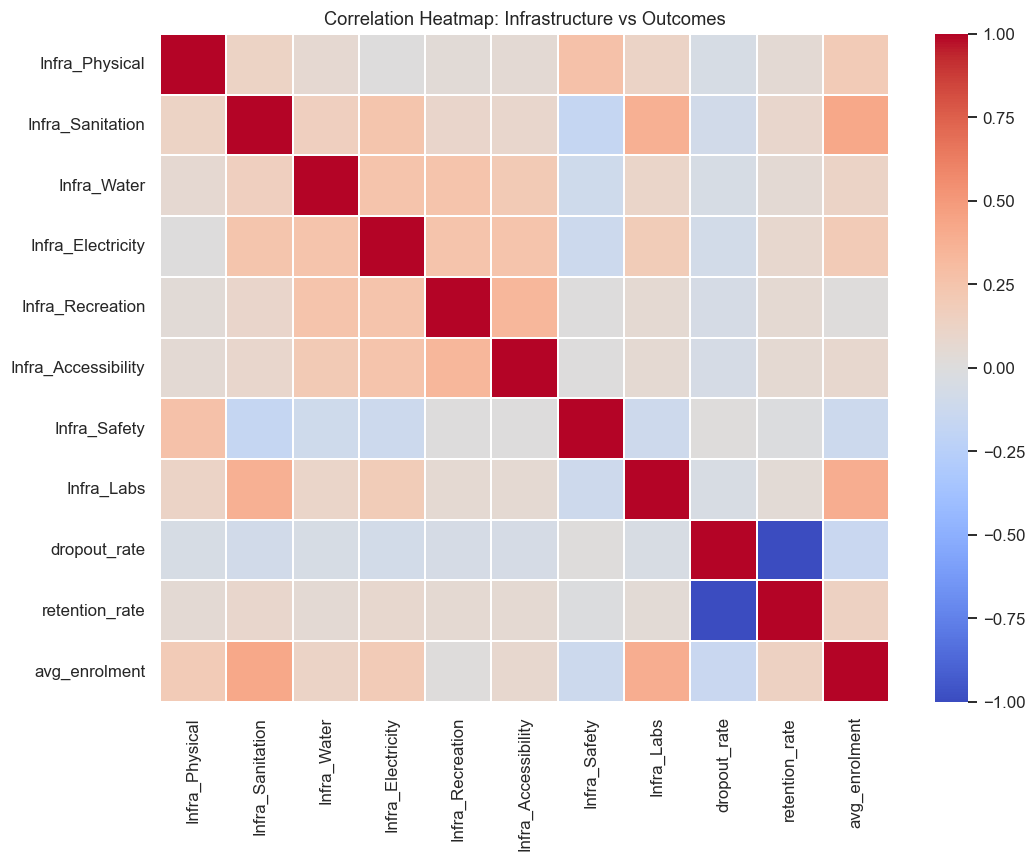

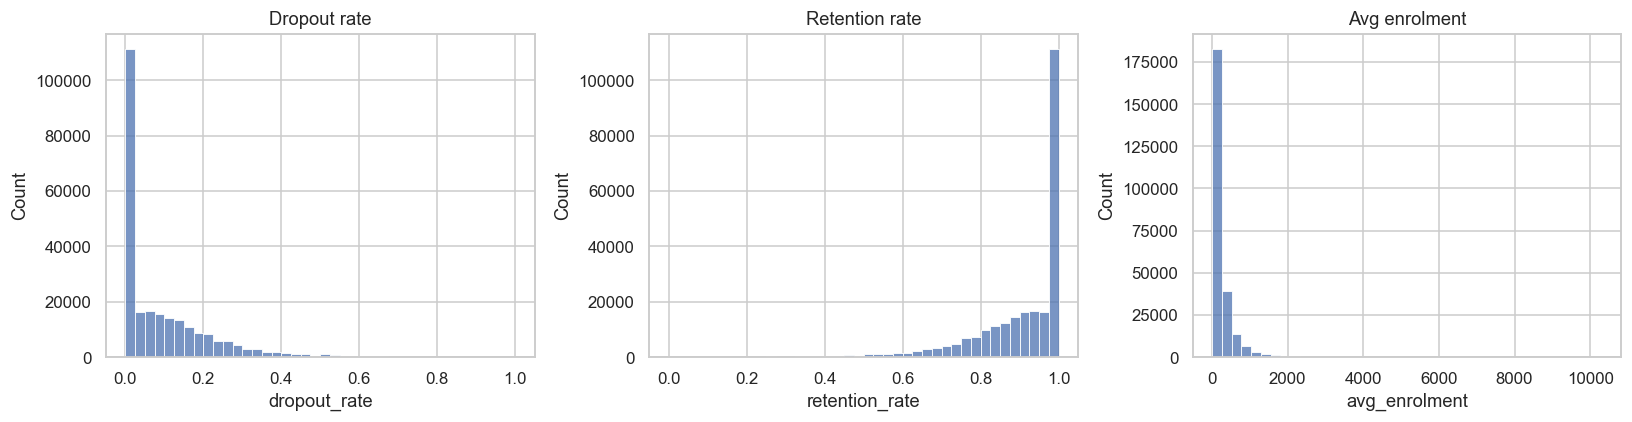

In [167]:
# ================================================================
# STEP 11: QUICK EDA — CORRELATIONS & DISTRIBUTIONS
# ================================================================
# sample for faster plotting (keeps structure; adjust n if your machine is beefy)
plot_sample = work_df.sample(n=min(250_000, len(work_df)), random_state=42)

# correlation heatmap between infra and targets
corr_cols = infra_features + targets
corr_mat = plot_sample[corr_cols].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_mat, annot=False, cmap="coolwarm", center=0, linewidths=0.3)
plt.title("Correlation Heatmap: Infrastructure vs Outcomes")
plt.tight_layout()
plt.show()

# distributions of targets
fig, axes = plt.subplots(1, 3, figsize=(15,4))
axes = axes.ravel()
sns.histplot(plot_sample['dropout_rate'], bins=40, ax=axes[0])
axes[0].set_title("Dropout rate")
sns.histplot(plot_sample['retention_rate'], bins=40, ax=axes[1])
axes[1].set_title("Retention rate")
sns.histplot(plot_sample['avg_enrolment'], bins=40, ax=axes[2])
axes[2].set_title("Avg enrolment")
plt.tight_layout()
plt.show()


In [175]:
targets = ['dropout_rate','avg_enrolment']

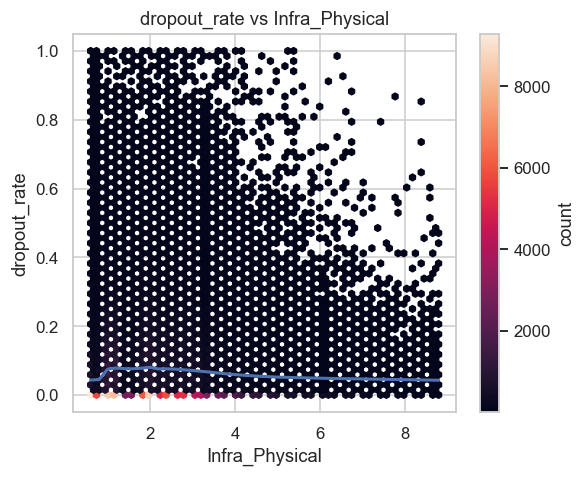

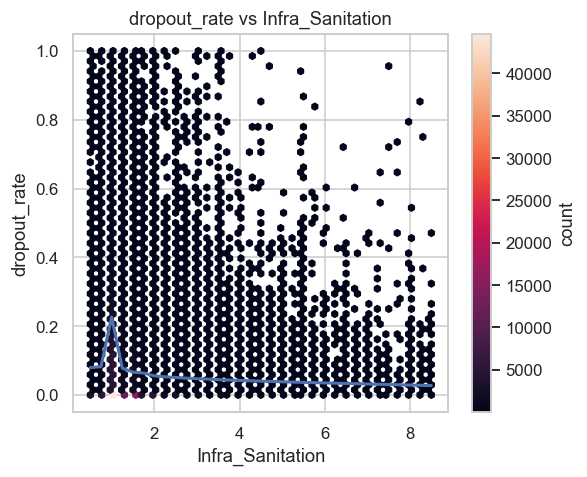

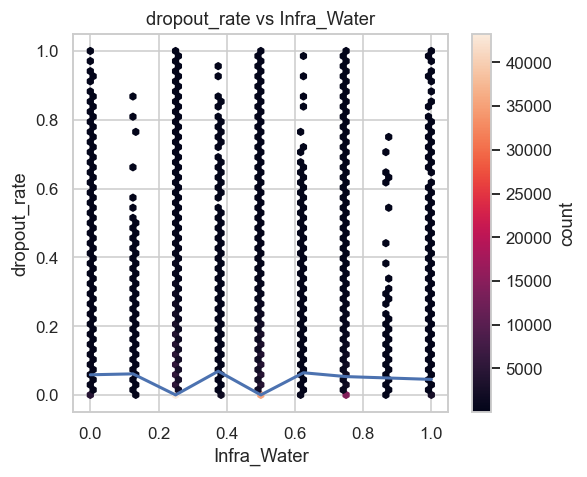

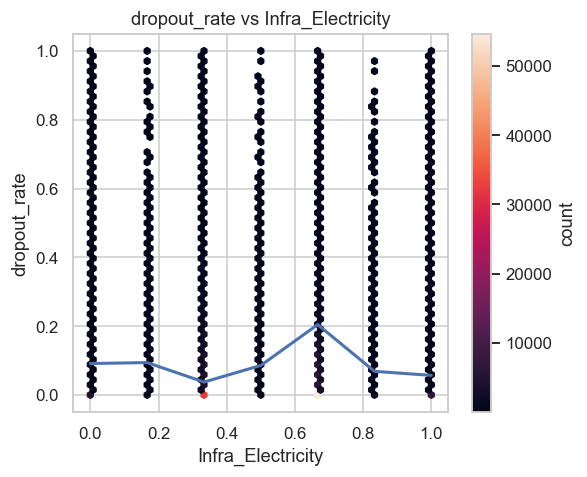

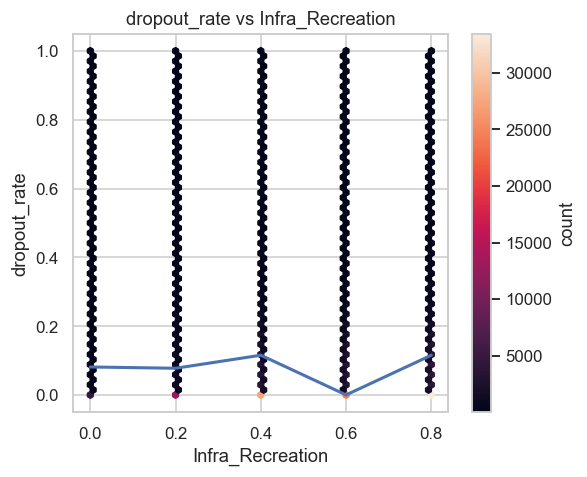

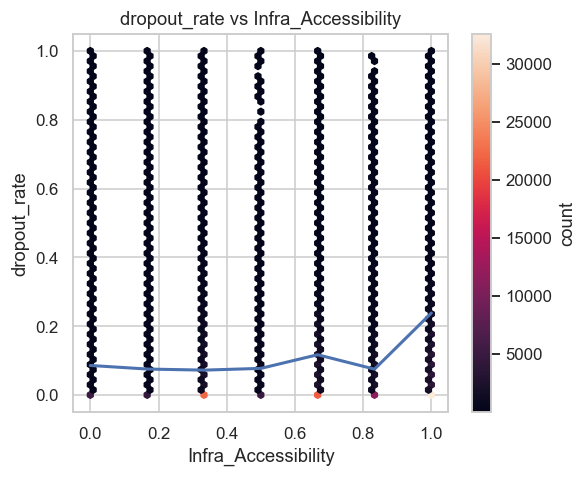

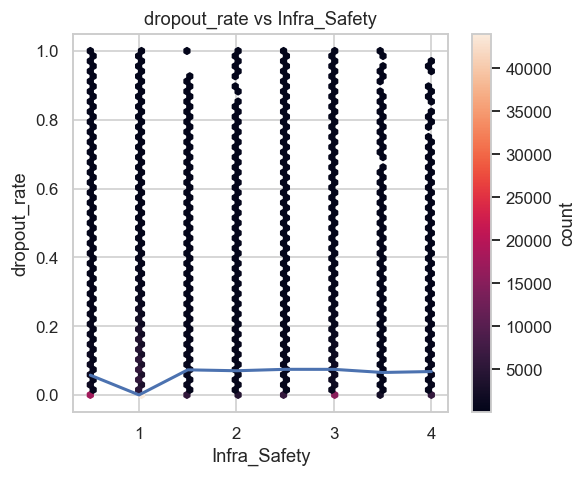

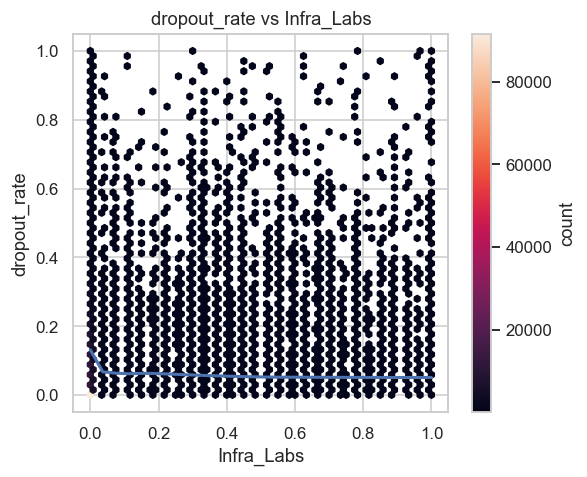

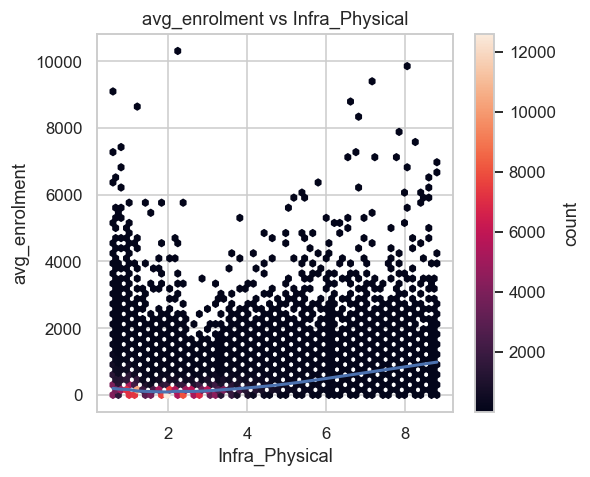

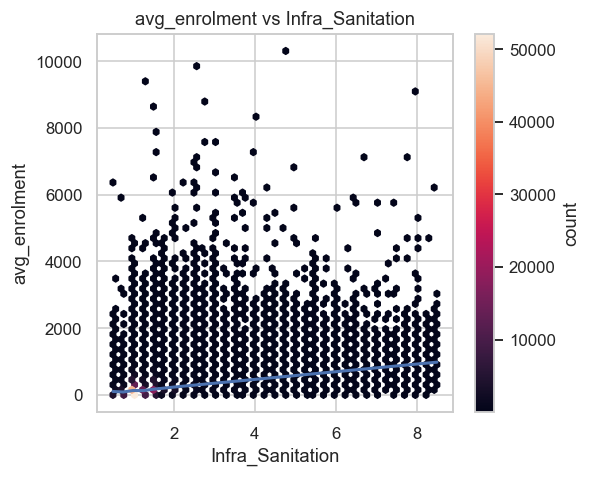

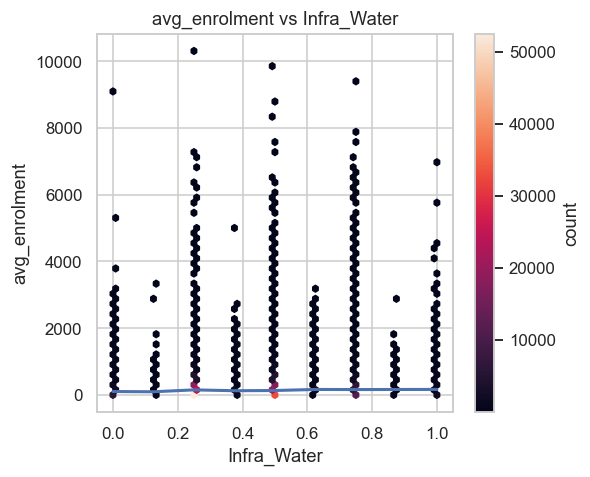

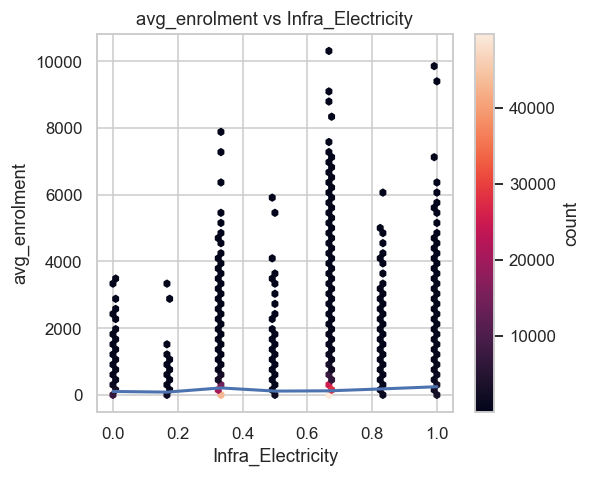

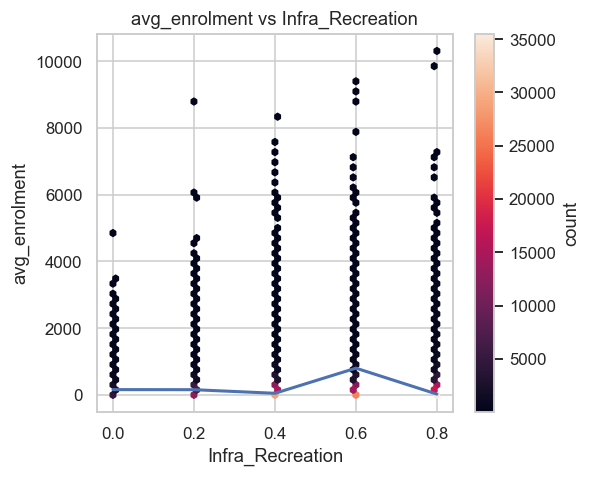

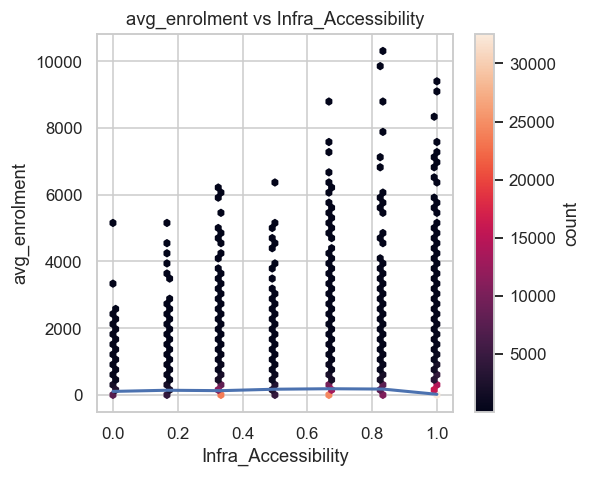

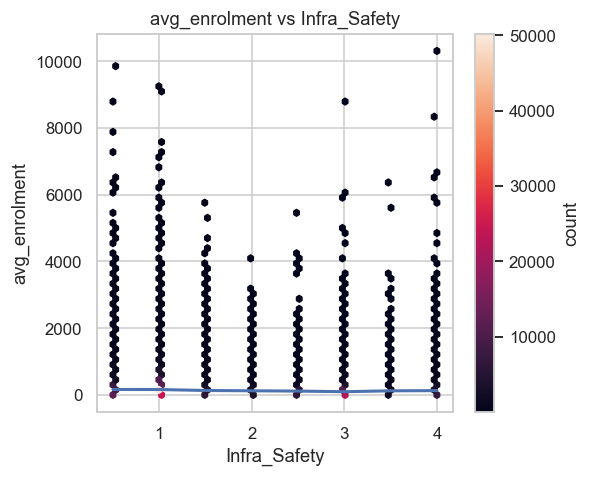

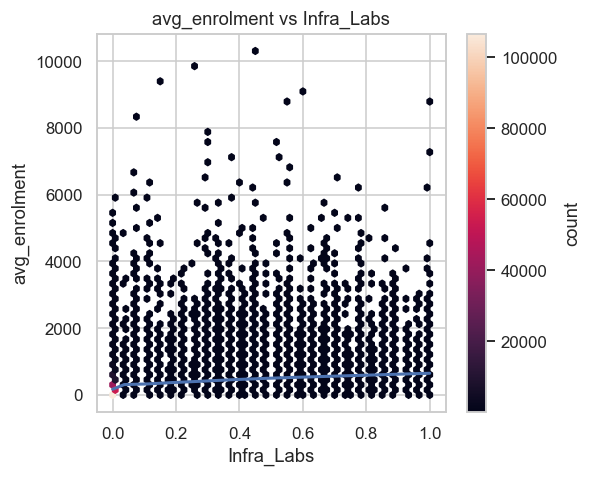

In [176]:
# ================================================================
# STEP 12: BIVARIATE RELATIONSHIPS — DENSITY + LOWESS
# ================================================================
def scatter_lowess(df, x, y, gridsize=60):
    plt.figure(figsize=(5.5,4.5))
    # hexbin for density
    hb = plt.hexbin(df[x], df[y], gridsize=gridsize, mincnt=1)
    # lowess trend
    lo = lowess(df[y], df[x], frac=0.2, return_sorted=True)
    plt.plot(lo[:,0], lo[:,1], lw=2)
    plt.xlabel(x); plt.ylabel(y)
    plt.title(f"{y} vs {x}")
    cb = plt.colorbar(hb); cb.set_label('count')
    plt.tight_layout(); plt.show()

for tgt in targets:
    for feat in infra_features:
        scatter_lowess(plot_sample, feat, tgt)



================ OLS for dropout_rate ================


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     5848.
Date:                Sun, 09 Nov 2025   Prob (F-statistic):               0.00
Time:                        02:48:47   Log-Likelihood:             1.6366e+06
No. Observations:             2776002   AIC:                        -3.273e+06
Df Residuals:                 2775993   BIC:                        -3.273e+06
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.1558      0.000    460.037      0.000       0.155       0.156
Infra_Physical         -0.0037   6.35e-05    -57.737      0.000      -0.004      -0.004
Infra_Sanitation       -0.0097   9.76e-05    -99.079      0.000      -0.010      -0.009
Infra_Water            -0.0073      0.000    -17.618      0.000      -0.008      -0.006
Infra_Electricity      -0.0300      0.000    -76.045      0.000      -0.031      -0.029
Infra_Recreation       -0.0168      0.000    -44.050      0.000      -0.018      -0.016
Infra_Accessibility    -0.0124      0.000    -43.344      0.000      -0.013      -0.012
Infra_Safety            0.0004   8.05e-05      5.226      0.000       0.000       0.001
Infra_Labs             -0.0062      0.001     -9.865      0.000      -0.007      -0.005
==============================================================================
Omnibus:                  1267637.972   Durbin-Watson:                   1.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          7328770.317
Skew:                           2.163   Prob(JB):                         0.00
Kurtosis:                       9.681   Cond. No.                         29.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

c:\Users\LAKSHYA\Downloads\Datathon 2025-20251106T122426Z-1-001\Datathon 2025\venv\Lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


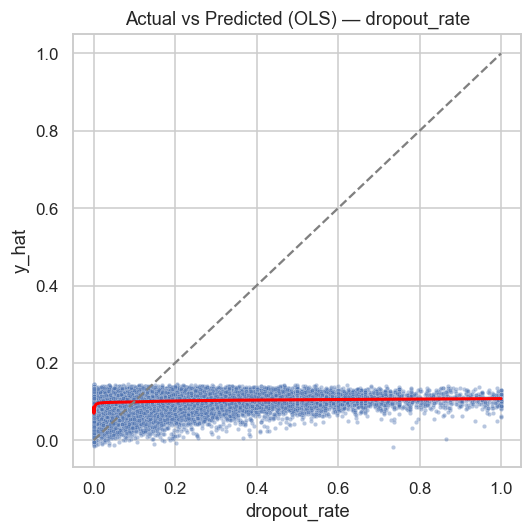


================ OLS for retention_rate ================


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     5848.
Date:                Sun, 09 Nov 2025   Prob (F-statistic):               0.00
Time:                        02:49:22   Log-Likelihood:             1.6366e+06
No. Observations:             2776002   AIC:                        -3.273e+06
Df Residuals:                 2775993   BIC:                        -3.273e+06
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.8442      0.000   2492.600      0.000       0.844       0.845
Infra_Physical          0.0037   6.35e-05     57.737      0.000       0.004       0.004
Infra_Sanitation        0.0097   9.76e-05     99.079      0.000       0.009       0.010
Infra_Water             0.0073      0.000     17.618      0.000       0.006       0.008
Infra_Electricity       0.0300      0.000     76.045      0.000       0.029       0.031
Infra_Recreation        0.0168      0.000     44.050      0.000       0.016       0.018
Infra_Accessibility     0.0124      0.000     43.344      0.000       0.012       0.013
Infra_Safety           -0.0004   8.05e-05     -5.226      0.000      -0.001      -0.000
Infra_Labs              0.0062      0.001      9.865      0.000       0.005       0.007
==============================================================================
Omnibus:                  1267637.978   Durbin-Watson:                   1.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          7328770.444
Skew:                          -2.163   Prob(JB):                         0.00
Kurtosis:                       9.681   Cond. No.                         29.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

c:\Users\LAKSHYA\Downloads\Datathon 2025-20251106T122426Z-1-001\Datathon 2025\venv\Lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


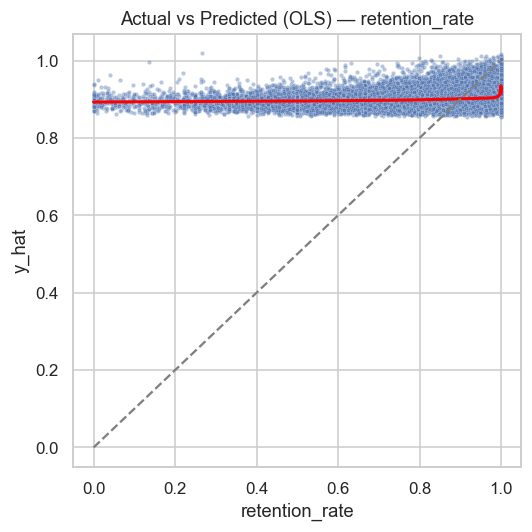


================ OLS for avg_enrolment ================


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                 1.316e+05
Date:                Sun, 09 Nov 2025   Prob (F-statistic):               0.00
Time:                        02:49:55   Log-Likelihood:            -1.9713e+07
No. Observations:             2776002   AIC:                         3.943e+07
Df Residuals:                 2775993   BIC:                         3.943e+07
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 -28.2758      0.741    -38.160      0.000     -29.728     -26.824
Infra_Physical         38.0920      0.139    274.106      0.000      37.820      38.364
Infra_Sanitation      104.4700      0.213    489.428      0.000     104.052     104.888
Infra_Water            35.1364      0.907     38.734      0.000      33.358      36.914
Infra_Electricity     120.2587      0.864    139.153      0.000     118.565     121.953
Infra_Recreation     -102.1534      0.834   -122.549      0.000    -103.787    -100.520
Infra_Accessibility    38.8059      0.625     62.130      0.000      37.582      40.030
Infra_Safety          -23.8733      0.176   -135.476      0.000     -24.219     -23.528
Infra_Labs            609.7431      1.379    442.169      0.000     607.040     612.446
==============================================================================
Omnibus:                  3041004.074   Durbin-Watson:                   1.153
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        739315934.014
Skew:                           5.222   Prob(JB):                         0.00
Kurtosis:                      82.263   Cond. No.                         29.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

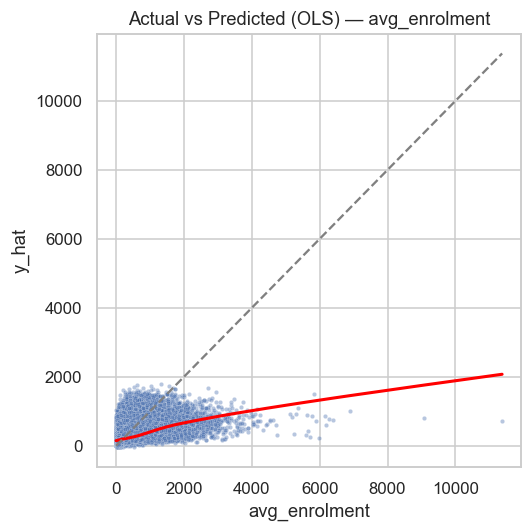

In [169]:
# ================================================================
# STEP 13: LINEAR MODEL (OLS) — ONE PER TARGET
# ================================================================
def run_ols(df, X_cols, y_col):
    X = df[X_cols].copy()
    y = df[y_col].values
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    print(f"\n================ OLS for {y_col} ================")
    display(model.summary())
    # quick goodness-of-fit plot on sample
    df_plot = df.sample(n=min(100_000, len(df)), random_state=7)
    Xp = sm.add_constant(df_plot[X_cols])
    df_plot['y_hat'] = model.predict(Xp)
    plt.figure(figsize=(5,5))
    sns.scatterplot(x=y_col, y='y_hat', data=df_plot, s=8, alpha=0.4)
    lo = lowess(df_plot['y_hat'], df_plot[y_col], frac=0.3, return_sorted=True)
    plt.plot(lo[:,0], lo[:,1], lw=2, color='red')
    m = df_plot[[y_col,'y_hat']].to_numpy()
    lo_diag = np.linspace(m[:,0].min(), m[:,0].max(), 100)
    plt.plot(lo_diag, lo_diag, '--', color='gray')
    plt.title(f"Actual vs Predicted (OLS) — {y_col}")
    plt.tight_layout(); plt.show()
    return model

ols_models = {}
for tgt in targets:
    ols_models[tgt] = run_ols(work_df, infra_features, tgt)


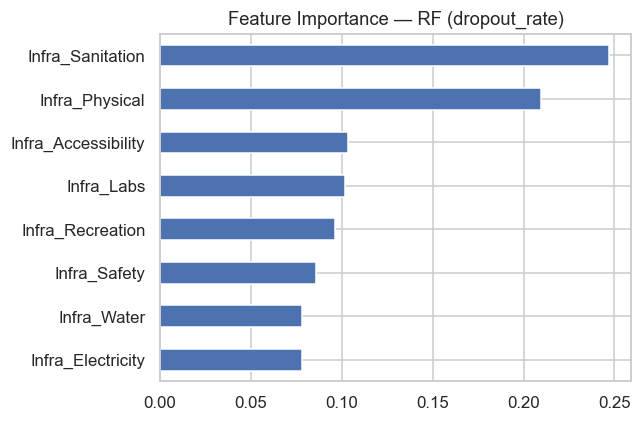

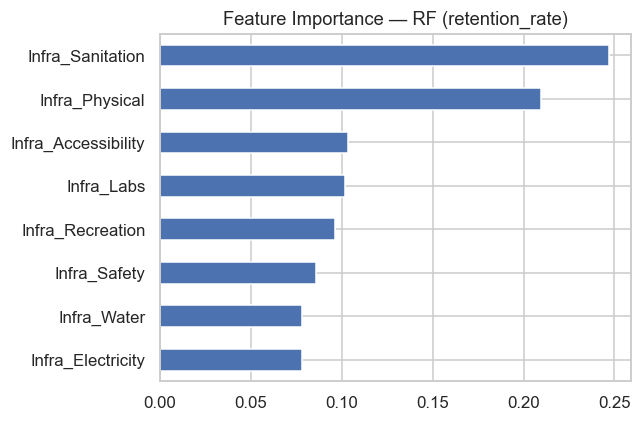

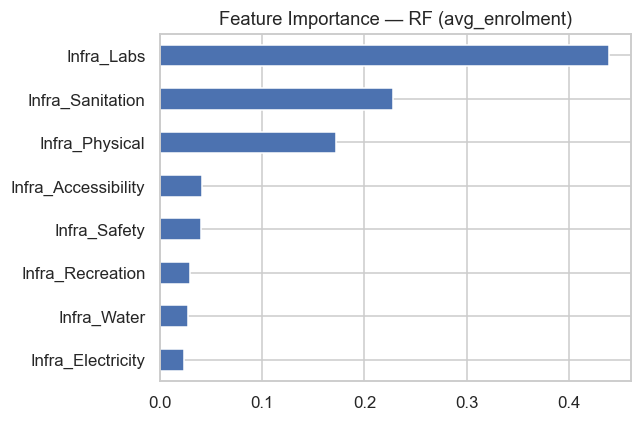

,target,model,R2,RMSE
0,dropout_rate,RandomForest,0.02,0.13
1,retention_rate,RandomForest,0.02,0.13
2,avg_enrolment,RandomForest,0.37,280.13


In [172]:
# ================================================================
# STEP 14: TREE MODEL (Random Forest) — TRAIN/TEST + IMPORTANCES
# ================================================================
metrics = []
rf_models = {}

for tgt in targets:
    X = work_df[infra_features].values
    y = work_df[tgt].values
    # downsample for speed (tree models can be slow on 2.7M)
    idx = np.random.RandomState(123).choice(len(work_df), size=min(400_000, len(work_df)), replace=False)
    Xs = X[idx]; ys = y[idx]
    X_train, X_test, y_train, y_test = train_test_split(Xs, ys, test_size=0.2, random_state=42)
    rf = RandomForestRegressor(
        n_estimators=300, max_depth=12, min_samples_leaf=5, n_jobs=-1, random_state=42
    )
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    metrics.append({'target': tgt, 'model': 'RandomForest', 'R2': r2, 'RMSE': rmse})
    rf_models[tgt] = rf

    # feature importances
    imp = pd.Series(rf.feature_importances_, index=infra_features).sort_values(ascending=True)
    plt.figure(figsize=(6,4))
    imp.plot(kind='barh')
    plt.title(f"Feature Importance — RF ({tgt})")
    plt.tight_layout(); plt.show()

pd.DataFrame(metrics)


In [ ]:
# ================================================================
# STEP 15: SHAP EXPLAINABILITY (on RF) — SAMPLE FOR SPEED
# ================================================================
# we'll do SHAP on dropout_rate model by default.
tgt = 'dropout_rate'
rf = rf_models[tgt]

# a smaller sample for SHAP (fast & readable)
expl_samp = work_df.sample(n=min(50_000, len(work_df)), random_state=101)
X_shap = expl_samp[infra_features]

# TreeExplainer for tree models (fast & exact)
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_shap)

# summary bar (global importance)
shap.summary_plot(shap_values, X_shap, plot_type="bar")

# beeswarm (directional effect)
shap.summary_plot(shap_values, X_shap)


In [ ]:
# ================================================================
# STEP 16: DEILE ANALYSIS — INFRAINDEX vs OUTCOMES (POLICY-FRIENDLY)
# ================================================================
# if you kept InfraIndex in final_df (good for narrative), use it:
if 'InfraIndex' in final_df.columns:
    dec = final_df[['InfraIndex'] + targets].copy()
    # deciles
    dec['decile'] = pd.qcut(dec['InfraIndex'].rank(method='first'), 10, labels=False) + 1
    dec_sum = dec.groupby('decile')[targets + ['InfraIndex']].mean().reset_index()
    print(dec_sum.round(4))

    # plot each outcome over deciles
    fig, axes = plt.subplots(1, 3, figsize=(15,4))
    for i, tgt in enumerate(targets):
        sns.lineplot(x='decile', y=tgt, data=dec_sum, marker='o', ax=axes[i])
        axes[i].set_title(f"{tgt} across InfraIndex deciles")
        axes[i].set_xlabel("InfraIndex decile (1 = lowest infra)")
    plt.tight_layout(); plt.show()
else:
    print("ℹ️ InfraIndex not found; skipping decile analysis.")


In [ ]:
# ================================================================
# STEP 17: SAVE KEY ARTIFACTS (OPTIONAL)
# ================================================================
os.makedirs("outputs", exist_ok=True)

# metrics table
pd.DataFrame(metrics).round(4).to_csv("outputs/model_metrics.csv", index=False)

# small sample for dashboarding / quick charts
work_df.sample(n=min(200_000, len(work_df)), random_state=7)\
       .to_csv("outputs_5/sampled_analysis_data.csv", index=False)

print("💾 Saved: outputs_%/model_metrics.csv & outputs/sampled_analysis_data.csv")
